In [61]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD
import cv2, numpy as np
import matplotlib.pyplot as plt
import pickle
import IPython
import time
from images2gif import writeGif
from PIL import Image
import theano.tensor as T
import scipy

# plot inline
%matplotlib inline

In [4]:
def ExpModel(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(1,100,100)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [22]:
model = ExpModel()
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

## Shapes

In [6]:
def get_squares(count = 100, size = 50, canvas_h = 224, canvas_w = 224):
    shapes = np.zeros((count, canvas_h, canvas_w))
    shapes_pil = []
    lmda = int(count/4)
    for i in xrange(count):
        x1 = int((canvas_h-size-1)*np.sin(np.pi*(i%lmda)/lmda))
        y1 = int((canvas_w-size-1)*np.sin(np.pi*(np.e*i%lmda)/lmda))
        x2,y2 = x1+size,y1+size
        shapes[i, x1:x2, y1], shapes[i, x1:x2, y2], \
            shapes[i, x1, y1:y2], shapes[i, x2, y1:y2] = 255, 255, 255, 255
        shapes_pil.append(Image.fromarray(np.uint8(shapes[i])))
    return shapes, shapes_pil

#x_jitter = 10
#y_jitter = 10
#x1 = min(abs(x1 + np.random.randint(-x_jitter, x_jitter+1)), canvas_img.shape[0]-sq_size-1)
#y1 = min(abs(y1 + np.random.randint(-y_jitter, y_jitter+1)), canvas_img.shape[1]-sq_size-1)

In [7]:
def get_triangles(count = 100, height = 50, canvas_h = 224, canvas_w = 224):
    base = 2*height
    shapes = np.zeros((count, canvas_h, canvas_w))
    shapes_pil = []
    lmda = int(count/4)
    for i in xrange(count):
        x1 = int((canvas_h-height-1)*np.sin(np.pi*(i%lmda)/lmda))
        y1 = int(base/2 + (canvas_w-base-1)*np.sin(np.pi*(np.e*i%lmda)/lmda))
        x2,y2,x3,y3 = x1+height, y1-base/2, x1+height, y1+base/2
        #print x1,x2,y1,y2, y3
        shapes[i, range(x1,x2), range(y2, y1)[::-1]] = 255
        shapes[i, range(x1,x3), range(y1,y3)] = 255
        shapes[i, x2, range(y2,y3)] = 255
        shapes_pil.append(Image.fromarray(np.uint8(shapes[i])))
    return shapes, shapes_pil

In [12]:
squares, squares_pil = get_squares(128, 20, 100, 100)

In [13]:
writeGif("./moving_squares.gif", squares_pil, duration=0.1, dither=0)

<img src="./moving_squares.gif"> <img>

In [10]:
triangles, triangles_pil = get_triangles(128, 20, 100, 100)

In [11]:
writeGif("./moving_triangles.gif", triangles_pil, duration=0.1, dither=0)

<img src="./moving_triangles.gif"><img>

## Training dataset

In [18]:
X_train = np.vstack([squares, triangles])
y_train = np.zeros((X_train.shape[0]), dtype=np.uint8)
y_train[len(squares):] = 1
X_train = X_train[np.newaxis].transpose(1,0,2,3)
y_train_cat = np_utils.to_categorical(y_train)

## Training time - tic toc tic toc... 

In [23]:
model.fit(X_train, y_train_cat, verbose=1, nb_epoch=10)

Epoch 1/10
256/256 [==============================] - 84s - loss: 6.7042     
Epoch 2/10
256/256 [==============================] - 86s - loss: 5.0123     
Epoch 3/10
256/256 [==============================] - 89s - loss: 4.5771     
Epoch 4/10
256/256 [==============================] - 92s - loss: 4.0817     
Epoch 5/10
256/256 [==============================] - 94s - loss: 3.6041     
Epoch 6/10
256/256 [==============================] - 92s - loss: 3.3877     
Epoch 7/10
256/256 [==============================] - 89s - loss: 2.5335     
Epoch 8/10
256/256 [==============================] - 91s - loss: 1.2354     
Epoch 9/10
256/256 [==============================] - 91s - loss: 0.8877     
Epoch 10/10
256/256 [==============================] - 86s - loss: 0.6498     


In [39]:
print "Training accuracy: ",np.mean(y_train == np.argmax(model.predict(X_train), axis=1))

Training accuracy:  1.0


In [25]:
model.layers

## Visualization

In [26]:
def visualizeWeights(w):
    plt.figure(figsize=(20, 20))
    F, C, H, W = w[0].shape
    rows, cols = int(np.sqrt(F))+1, int(np.sqrt(F))+1
    for filter_no in range(F):
        plt.subplot(rows, cols,filter_no+1)
        plt.axis('off')
        plt.imshow(w[0][filter_no,0,:,:], cmap='gray', interpolation='none') # bias not shown

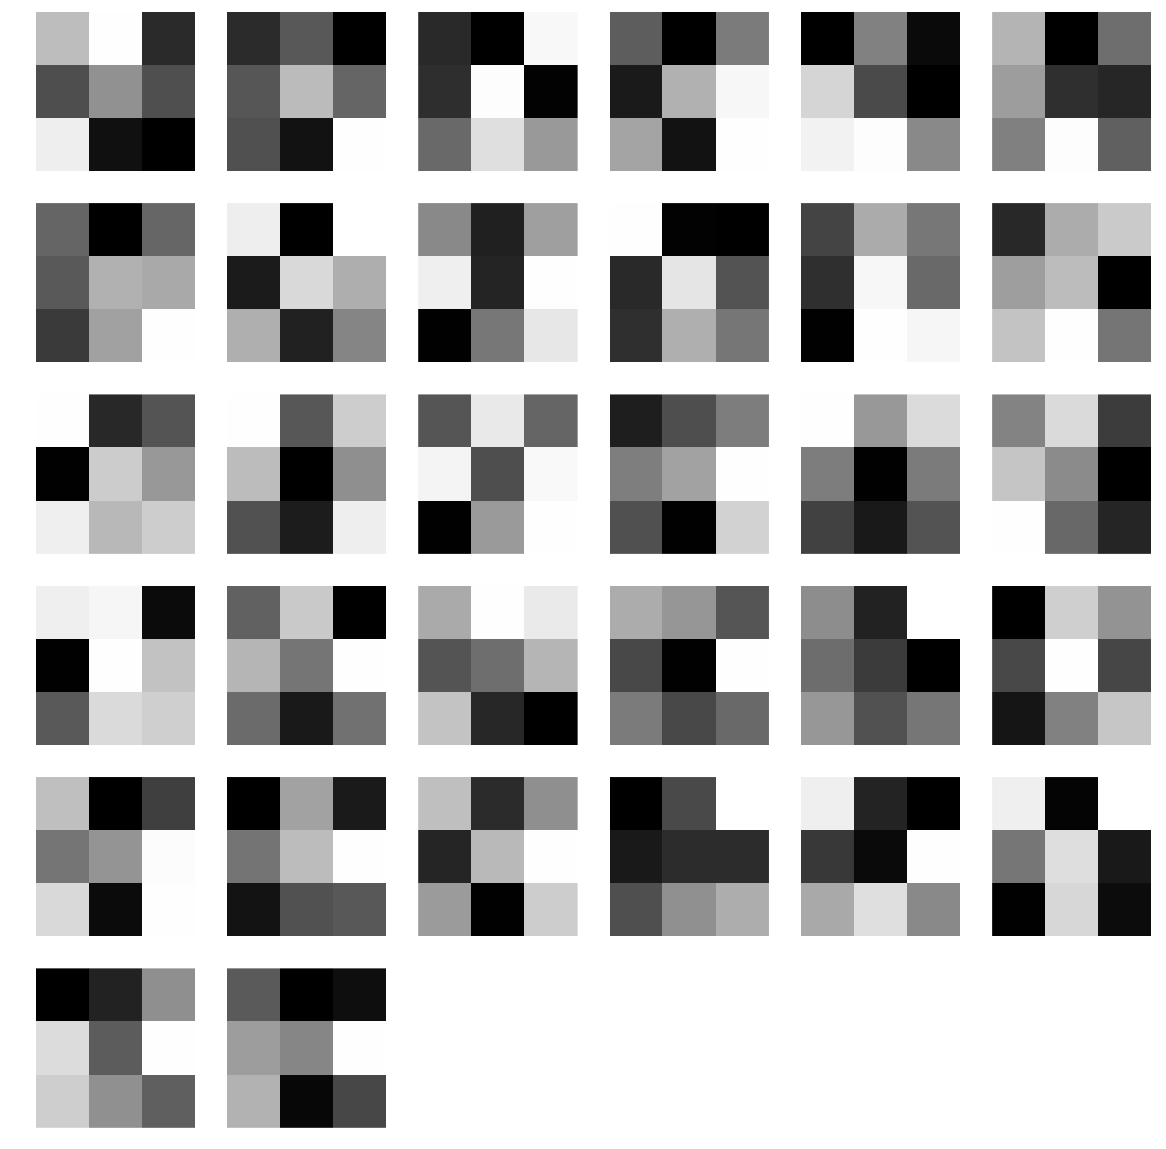

In [27]:
visualizeWeights(model.layers[1].get_weights())

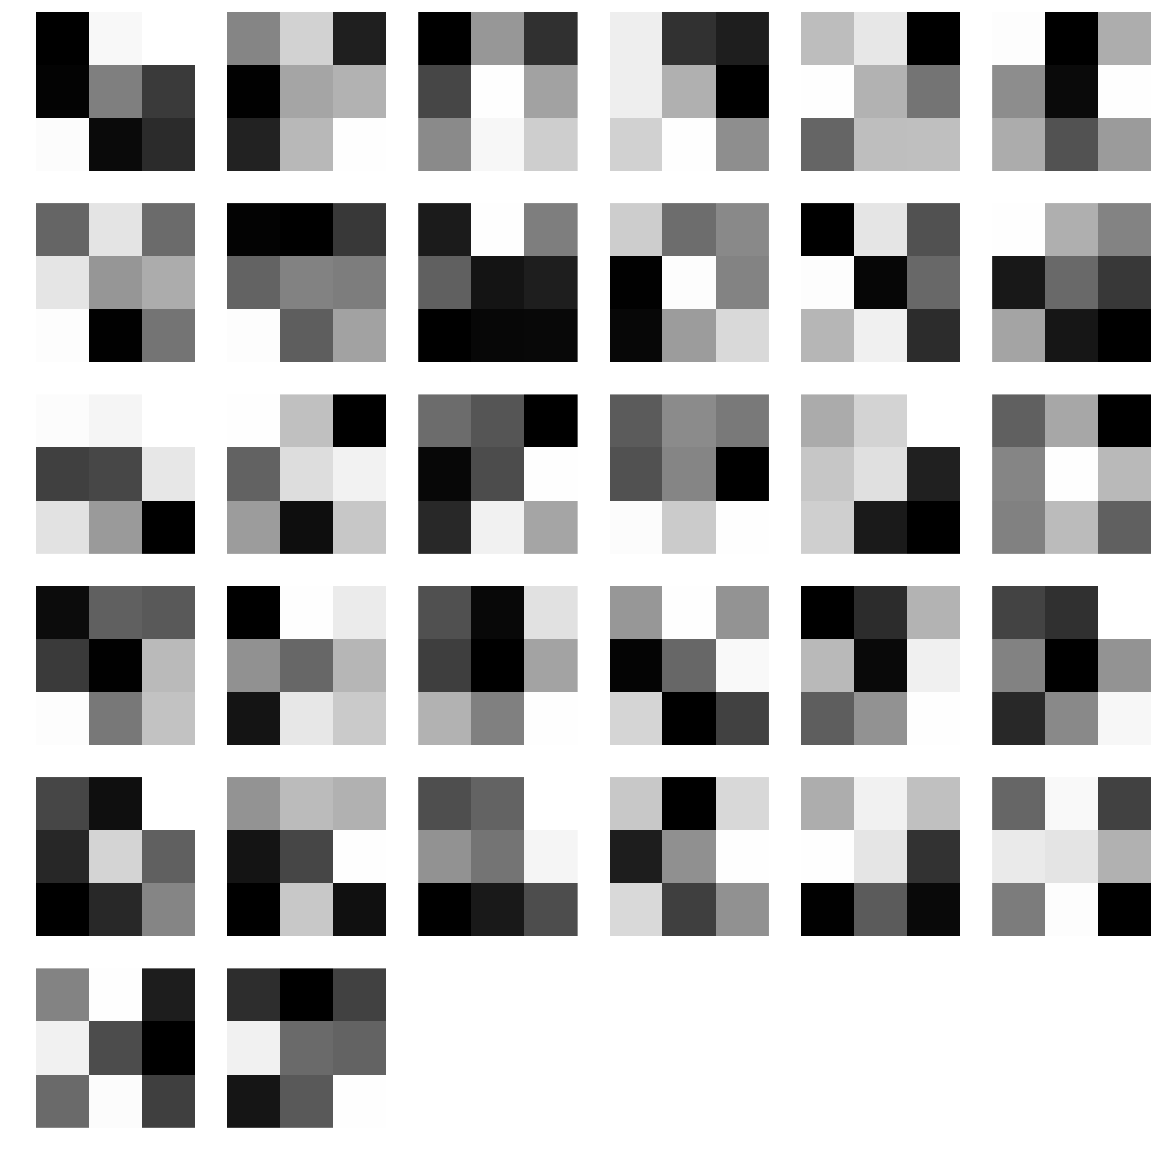

In [28]:
visualizeWeights(model.layers[3].get_weights())

## Test with larger shapes

In [77]:
def get_squares_rotated(count = 100, size = 50, canvas_h = 224, canvas_w = 224):
    shapes = np.zeros((count, canvas_h, canvas_w))
    shapes_pil = []
    lmda = int(count/4)
    for i in xrange(count):
        x1 = int((canvas_h-size-1)*np.sin(np.pi*(i%lmda)/lmda))
        y1 = int((canvas_w-size-1)*np.sin(np.pi*(np.e*i%lmda)/lmda))
        x2,y2 = x1+size,y1+size
        shapes[i, x1:x2, y1], shapes[i, x1:x2, y2], \
            shapes[i, x1, y1:y2], shapes[i, x2, y1:y2] = 255, 255, 255, 255
        shape_rot = scipy.ndimage.interpolation.rotate(shapes[i], i*5, order=1, reshape=False)
        shapes_pil.append(Image.fromarray(np.uint8(shape_rot)))
    return shapes, shapes_pil

def get_triangles_rotated(count = 100, height = 50, canvas_h = 224, canvas_w = 224):
    base = 2*height
    shapes = np.zeros((count, canvas_h, canvas_w))
    shapes_pil = []
    lmda = int(count/4)
    for i in xrange(count):
        x1 = int((canvas_h-height-1)*np.sin(np.pi*(i%lmda)/lmda))
        y1 = int(base/2 + (canvas_w-base-1)*np.sin(np.pi*(np.e*i%lmda)/lmda))
        x2,y2,x3,y3 = x1+height, y1-base/2, x1+height, y1+base/2
        #print x1,x2,y1,y2, y3
        shapes[i, range(x1,x2), range(y2, y1)[::-1]] = 255
        shapes[i, range(x1,x3), range(y1,y3)] = 255
        shapes[i, x2, range(y2,y3)] = 255
        shape_rot = scipy.ndimage.interpolation.rotate(shapes[i], i*5, order=1, reshape=False)
        shapes_pil.append(Image.fromarray(np.uint8(shape_rot)))
    return shapes, shapes_pil

In [80]:
sqaures_test, sqaures_test_pil = get_squares_rotated(100, 40, 100, 100)
triangles_test, triangles_test_pil  = get_triangles_rotated(100, 40, 100, 100)
X_test = np.vstack([sqaures_test, triangles_test])
y_test = np.zeros((X_test.shape[0]), dtype=np.uint8)
y_test[len(sqaures_test):] = 1
X_test = X_test[np.newaxis].transpose(1,0,2,3)
y_test_cat = np_utils.to_categorical(y_test)

In [82]:
# save as gif
writeGif("./moving_squares_large.gif", sqaures_test_pil, duration=0.1, dither=0)
writeGif("./moving_triangles_large.gif", triangles_test_pil, duration=0.1, dither=0)

<img src="./moving_squares_large.gif"><img>

<img src="./moving_triangles_large.gif"><img>

In [83]:
print "Test accuracy: ",np.mean(y_test == np.argmax(model.predict(X_test), axis=1))

Test accuracy:  0.995


## Image generation

In [140]:

D = T.matrix() # desired
Y = model.get_output()
xent = -D * T.log(Y) - (1-D) * T.log(1-Y)
Cost = xent.mean() 
gradients = [T.grad(Cost, p) for p in model.get_params()[0]]